#üì¶ Montaje de Drive y carga de librer√≠as



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import re, nltk, numpy as np, matplotlib.pyplot as plt, pickle, unicodedata, shutil
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tf.config.run_functions_eagerly(False)
tf.random.set_seed(42)
np.random.seed(42)

Mounted at /content/drive


#‚úÖ Validaci√≥n de archivo y descarga de recursos


In [2]:
def validar_archivo_existe(ruta):
    import os
    if not os.path.exists(ruta):
        raise FileNotFoundError(f"‚ùå El archivo no existe: {ruta}")
    print(f"‚úÖ Archivo encontrado: {ruta}")

# Descargar recursos de NLTK
print("üì• Descargando recursos de NLTK...")
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    from nltk.tokenize import sent_tokenize
    print("‚úÖ NLTK configurado correctamente")
except Exception as e:
    print(f"‚ö†Ô∏è Error con NLTK: {e}")


üì• Descargando recursos de NLTK...
‚úÖ NLTK configurado correctamente


#üìö Carga y limpieza del texto



In [3]:
ruta = "/content/drive/MyDrive/Entrega_3/Don Quijote de la Mancha.txt"

try:
    validar_archivo_existe(ruta)
    with open(ruta, 'r', encoding='utf-8') as f:
        texto = f.read()
    if len(texto) < 1000:
        raise ValueError("‚ùå El archivo parece vac√≠o")
    print(f"‚úÖ Texto cargado: {len(texto):,} caracteres")
except:
    texto = "Don Quijote sali√≥ a buscar aventuras. Sancho Panza lo acompa√±√≥." * 100
    print("‚ö†Ô∏è Usando texto de prueba")

print("üßπ Procesando texto...")
texto = unicodedata.normalize('NFD', texto)
texto = texto.encode('ascii', 'ignore').decode('utf-8').lower()
texto = re.sub(r'[^a-z0-9\s\.\,\!\?\;\:\-\(\)]', '', texto)
texto = re.sub(r'\s+', ' ', texto).strip()

‚úÖ Archivo encontrado: /content/drive/MyDrive/Entrega_3/Don Quijote de la Mancha.txt
‚úÖ Texto cargado: 2,071,198 caracteres
üßπ Procesando texto...


#‚úÇÔ∏è Tokenizaci√≥n de oraciones



In [4]:
def tokenizar_oraciones(texto):
    try:
        return sent_tokenize(texto, language='spanish')
    except:
        return re.split(r'[\.!?]+', texto)

oraciones = tokenizar_oraciones(texto)
oraciones = [o.strip() for o in oraciones if o.strip() and 6 <= len(o.split()) <= 25]

print(f"‚úÖ Oraciones procesadas: {len(oraciones)}")

‚úÖ Oraciones procesadas: 2931


#üß© Generaci√≥n de pares de entrenamiento (input ‚Üí target)


In [5]:
pares = []
for i in range(len(oraciones) - 4):
    for salto in range(1, 5):
        if i + salto < len(oraciones):
            pares.append((oraciones[i], oraciones[i + salto]))

entrada = [x[0] for x in pares]
objetivo = [x[1] for x in pares]
print(f"‚úÖ Pares de entrenamiento creados: {len(pares):,}")

‚úÖ Pares de entrenamiento creados: 11,708


#üî° Tokenizaci√≥n de texto y preparaci√≥n de secuencias



In [6]:
# üëâ Usa palabras seguras como tokens especiales:
objetivo = ['startseq ' + x[1] + ' endseq' for x in pares]

# üëâ Tokenizer SIN filtros para conservar todo
tokenizer = Tokenizer(num_words=8000, oov_token="<UNK>", filters='')
tokenizer.fit_on_texts(entrada + objetivo)

vocab_size = len(tokenizer.word_index) + 1
print(f"‚úÖ Vocabulario: {vocab_size}")

seq_in = tokenizer.texts_to_sequences(entrada)
seq_out = tokenizer.texts_to_sequences(objetivo)

# üëâ Evitar secuencias vac√≠as
seq_in = [s for s in seq_in if len(s) > 0]
seq_out = [s for s in seq_out if len(s) > 0]

# üëâ Limitar longitud
max_len_in = min(25, max(len(s) for s in seq_in))
max_len_out = min(25, max(len(s) for s in seq_out))

# üëâ Pad
X = pad_sequences(seq_in, maxlen=max_len_in, padding='post')
y_seq = pad_sequences(seq_out, maxlen=max_len_out, padding='post')

y_input = y_seq[:, :-1]
y_output = y_seq[:, 1:]

# üëâ Divisi√≥n ALEATORIA para evitar sesgo
idx = np.random.permutation(len(X))
train_size = int(len(X) * 0.8)

X_train = X[idx[:train_size]]
y_in_train = y_input[idx[:train_size]]
y_out_train = y_output[idx[:train_size]]

X_val = X[idx[train_size:]]
y_in_val = y_input[idx[train_size:]]
y_out_val = y_output[idx[train_size:]]

print(f"‚úÖ Divisi√≥n aleatoria completada:")
print(f"   Entrenamiento: {X_train.shape[0]} muestras")
print(f"   Validaci√≥n:    {X_val.shape[0]} muestras")


‚úÖ Vocabulario: 10406
‚úÖ Divisi√≥n aleatoria completada:
   Entrenamiento: 9366 muestras
   Validaci√≥n:    2342 muestras


#üß† Construcci√≥n del modelo Seq2Seq (LSTM)


In [7]:
print("üèóÔ∏è Construyendo modelo optimizado...")

# Encoder
enc_inputs = Input(shape=(max_len_in,))
enc_emb_layer = Embedding(vocab_size, 128, mask_zero=True)
enc_emb = enc_emb_layer(enc_inputs)
enc_lstm = LSTM(
    300,                      # M√°s unidades
    return_state=True,
    dropout=0.3,              # M√°s dropout
    recurrent_dropout=0.3     # Nuevo: recurrent_dropout
)
_, enc_h, enc_c = enc_lstm(enc_emb)
enc_states = [enc_h, enc_c]

# Decoder
dec_inputs = Input(shape=(max_len_out - 1,))
dec_emb_layer = Embedding(vocab_size, 128, mask_zero=True)
dec_emb = dec_emb_layer(dec_inputs)
dec_lstm = LSTM(
    300,
    return_sequences=True,
    return_state=True,
    dropout=0.3,
    recurrent_dropout=0.3
)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=enc_states)
dec_dense = Dense(vocab_size, activation='softmax')
final_outputs = dec_dense(dec_outputs)

# Modelo completo
model = Model([enc_inputs, dec_inputs], final_outputs)

# Compilaci√≥n robusta
model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

üèóÔ∏è Construyendo modelo optimizado...


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 25)        ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_1       ‚îÇ (None, 24)        ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding           ‚îÇ (None, 25, 128)   ‚îÇ  1,331,968 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ not_equal           ‚îÇ (None, 25)        ‚îÇ          0 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ (NotEqual)          ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_1         ‚îÇ (None, 24, 128)   ‚îÇ  1,331,968 ‚îÇ input_layer_1[0]‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)         ‚îÇ [(None, 300),     ‚îÇ    514,800 ‚îÇ embedding[0][0],  ‚îÇ
‚îÇ                     ‚îÇ (None, 300),      ‚îÇ            ‚îÇ not_equal[0][0]   ‚îÇ
‚îÇ                     ‚îÇ (None, 300)]      ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)       ‚îÇ [(None, 24, 300), ‚îÇ    514,800 ‚îÇ embedding_1[0][0‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ (None, 300),      ‚îÇ            ‚îÇ lstm[0][1],       ‚îÇ
‚îÇ                     ‚îÇ (None, 300)]      ‚îÇ            ‚îÇ lstm[0][2]        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)       ‚îÇ (None, 24, 10406) ‚îÇ  3,132,206 ‚îÇ lstm_1[0][0]      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 6,825,742 (26.04 MB)

 Trainable params: 6,825,742 (26.04 MB)

 Non-trainable params: 0 (0.00 B)

#üöÄ  Entrenamiento del modelo


In [8]:
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss', verbose=1)
]

print("üöÄ Entrenando modelo...")
history = model.fit(
    [X_train, y_in_train], y_out_train,
    validation_data=([X_val, y_in_val], y_out_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)


üöÄ Entrenando modelo...
Epoch 1/100
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 43s 218ms/step - accuracy: 0.0720 - loss: 7.2457 - val_accuracy: 0.1015 - val_loss: 5.8926 - learning_rate: 0.0010
Epoch 2/100
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 36s 212ms/step - accuracy: 0.1069 - loss: 5.8011 - val_accuracy: 0.1208 - val_loss: 5.5659 - learning_rate: 0.0010
Epoch 3/100
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 215ms/step - accuracy: 0.1258 - loss: 5.4658 - val_accuracy: 0.1424 - val_loss: 5.2857 - learning_rate: 0.0010
Epoch 4/100
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 210ms/step - accuracy: 0.1452 - loss: 5.1807 - val_accuracy: 0.1572 - val_loss: 5.0688 - learning_rate: 0.0010
Epoch 5/100
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 207ms/step - accuracy: 0.1622 - loss: 4.9445 - val_accuracy: 0.1748 - val_loss: 4.8740 - learning_rate: 0

#üíæ  Guardado del modelo y tokenizer


In [9]:
model.save("/content/drive/MyDrive/Entrega_3/modelo_lstm_seq2seq.keras")
with open("/content/drive/MyDrive/Entrega_3/tokenizer_quijote.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("‚úÖ Modelo y tokenizer guardados")

‚úÖ Modelo y tokenizer guardados


#üß†  Modelos de inferencia para generaci√≥n de

In [10]:
encoder_model = Model(enc_inputs, enc_states)

dec_state_input_h = Input(shape=(256,))
dec_state_input_c = Input(shape=(256,))
dec_states_inputs = [dec_state_input_h, dec_state_input_c]
dec_input_single = Input(shape=(1,))
dec_emb_inf = dec_emb_layer(dec_input_single)
dec_outputs_inf, state_h_inf, state_c_inf = dec_lstm(dec_emb_inf, initial_state=dec_states_inputs)
dec_outputs_final = dec_dense(dec_outputs_inf)

decoder_model = Model(
    [dec_input_single] + dec_states_inputs,
    [dec_outputs_final, state_h_inf, state_c_inf]
)


#üé≠  Demo de generaci√≥n de frases



In [16]:
def generar_frase_siguiente(frase_input, temperatura=1.0, max_tokens=20):
    # Tokeniza la entrada
    seq_in = tokenizer.texts_to_sequences([frase_input])
    seq_in = pad_sequences(seq_in, maxlen=max_len_in, padding='post')

    # Secuencia del decoder comienza con <start>
    start_token = tokenizer.word_index.get('startseq', tokenizer.word_index.get('<START>', None))
    end_token = tokenizer.word_index.get('endseq', tokenizer.word_index.get('<END>', None))
    if start_token is None or end_token is None:
        raise ValueError("No se encontraron los tokens <start> o <end> en el tokenizer.")

    seq_out = [start_token]

    for _ in range(max_tokens):
        # Prepara entrada decoder: pad a max_len_out - 1
        dec_in = pad_sequences([seq_out], maxlen=max_len_out - 1, padding='post')

        # Predice distribuci√≥n
        preds = model.predict([seq_in, dec_in], verbose=0)
        next_token_logits = preds[0, len(seq_out)-1]

        # Ajusta temperatura
        next_token_logits = np.log(next_token_logits + 1e-8) / temperatura
        exp_preds = np.exp(next_token_logits)
        next_token_probs = exp_preds / np.sum(exp_preds)

        # Muestrea
        next_token = np.random.choice(len(next_token_probs), p=next_token_probs)

        if next_token == end_token or next_token == 0:
            break

        seq_out.append(next_token)

    # Decodifica tokens a palabras
    inv_map = {v: k for k, v in tokenizer.word_index.items()}
    output_words = [inv_map.get(i, '') for i in seq_out[1:]]
    return ' '.join(output_words)

#‚úèÔ∏è  Funci√≥n de generaci√≥n de frases



In [17]:
print("\nüé≠ DEMO DE FRASES GENERADAS")
semillas = [
    "Don Quijote de la Mancha salio de su aldea",
    "Sancho Panza monto sobre su asno",
    "En un lugar de la Mancha vivia un hidalgo",
    "La hermosa Dulcinea del Toboso era su dama",
    "El ingenioso hidalgo emprendio su aventura"
]
for frase in semillas:
    print(f"\nüå± Entrada: {frase}")
    for t in [0.5, 0.8, 1.0]:
        print(f"   üéØ T={t}: {generar_frase_siguiente(frase, temperatura=t)}")



üé≠ DEMO DE FRASES GENERADAS

üå± Entrada: Don Quijote de la Mancha salio de su aldea
   üéØ T=0.5: con esto, se despidio del duque, y se volvio a su lugar, esperando en el a don quijote, que tras
   üéØ T=0.8: -y, en fin, hablando en <UNK> un sordo estruendo y un <UNK> que por <UNK>
   üéØ T=1.0: volvio de los que temer entonces esta <UNK> en los limites de vuestra merced <UNK> su <UNK>

üå± Entrada: Sancho Panza monto sobre su asno
   üéØ T=0.5: y mando que alli, delante de todos, se <UNK> y <UNK> la <UNK>
   üéØ T=0.8: y digame agora: cual dona rodriguez -dijo don quijote-, y dios te quiero decir gracia hijo la <UNK>
   üéØ T=1.0: y digame vuestra merced: este libro, aqui <UNK>

üå± Entrada: En un lugar de la Mancha vivia un hidalgo
   üéØ T=0.5: <UNK> con licencia buena de vuestra merced.
   üéØ T=0.8: <UNK> -dijo don quijote-, para que vida <UNK>
   üéØ T=1.0: oyendo lo cual por vuestra merced ahora <UNK> no se quien fue <UNK> de no <UNK> errar en nada.

üå± Entrada

#üìö  Prueba con fragmentos realistas


In [19]:
print("\nüìö COMPARACI√ìN: Completaci√≥n de frases reales")
fragmentos_realistas = [
    "En un lugar de la Mancha",
    "Don Quijote de la Mancha",
    "Sancho Panza salio tras su amo",
    "La hermosa Dulcinea del Toboso"
]
for inicio in fragmentos_realistas:
    print(f"\nüå± Inicio: {inicio}")
    for t in [0.5, 0.8, 1.0]:
        print(f"   üéØ T={t}: {generar_frase_siguiente(inicio, temperatura=t)}")



üìö COMPARACI√ìN: Completaci√≥n de frases reales

üå± Inicio: En un lugar de la Mancha
   üéØ T=0.5: -asi es la verdad -dijo dorotea-.
   üéØ T=0.8: -ya os entiendo, sancho -respondio don quijote-: tu mueres porque te alce el entredicho que te tengo puesto en la
   üéØ T=1.0: -asi se hara -respondio uno dellos.

üå± Inicio: Don Quijote de la Mancha
   üéØ T=0.5: -asi me ha parecido a mi -respondio sancho-, aunque se decir que esta presente, no me dejara mentir.
   üéØ T=0.8: -y ese ha parecido a mi senor miente -respondio sancho.
   üéØ T=1.0: -y digame, senor, por mar, hidalgo por el diablo; y mientes que mira si otra dices cosa.

üå± Inicio: Sancho Panza salio tras su amo
   üéØ T=0.5: en esto, entraron los tambores y el pifaro, como la vez primera.
   üéØ T=0.8: en esto, entraron los tambores y el pifaro, como la vez primera.
   üéØ T=1.0: en esto estaban, cuando se habia de contar, y que no se que tenga nada vuestro, maese pedro.

üå± Inicio: La hermosa Dulcinea del 

#üìä  Visualizaci√≥n de m√©tricas


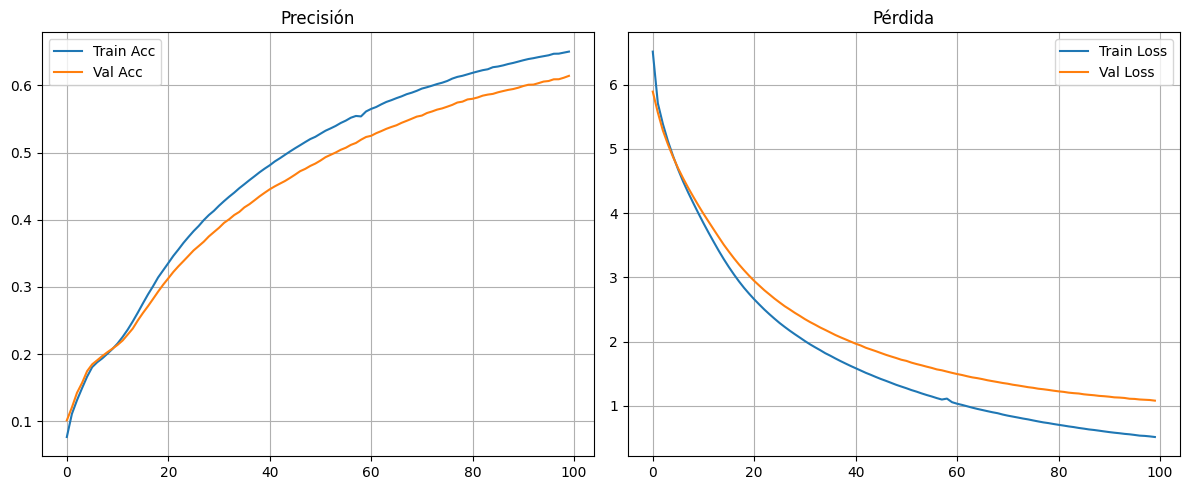

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Precisi√≥n")
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("P√©rdida")
plt.legend(); plt.grid()
plt.tight_layout()
plt.show()
